## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change folder according to your convenience
cd drive/MyDrive/HAR_Project/Exp2

/content/drive/MyDrive/HAR_Project/Exp2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


## Loading and preparing train and test data

We use "Sensors Activity Dataset" by Shoaib et al. which is available for download from [here](https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar).
There are 7 activities in this dataset: Biking, Downstairs, Jogging, Sitting, Standing, Upstairs, Walking. 
There were ten participants involved in data collection experiment who performed  each of these activities for 3-4 minutes.
All ten participants were male, between the ages of 25 and 30. 
Each of these participants was equipped with five smartphones on five body positions: 

1. One in their right jean’s pocket. 
2. One in their left jean’s pocket.
3. One on belt position towards the right leg using a belt clipper.
4. One on the right upper arm. 
5. One on the right wrist.

The data was collected for an accelerometer, a gyroscope, a magnetometer, and a linear acceleration sensor. 
Each csv file contains data for each participant's seven physical activities for all five positions. 

Notation in these files: 

Accelerometer ( Ax = x-axis, Ay = y-axis, Az= Z-aixs)   
Linear Acceleration Sensor ( Lx = x-axis, Ly = y axis, Lz= Z-aixs)   
Gyroscope ( Gx = x-axis, Gy = y-axis, Gz= Z-aixs)   
Magnetometer ( Mx = x-axis, My = y-axis, Mz= Z-aixs) 

Note: We will use only the 1st 3 sensors for now

In [5]:
# Download dataset
! wget https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar -P ../data/

# Extract dataset using unrar
!pip install unrar
!unrar e ../data/sensors-activity-recognition-dataset-shoaib.rar ../data/

--2022-07-16 14:08:39--  https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar
Resolving www.utwente.nl (www.utwente.nl)... 130.89.3.249, 2001:67c:2564:a102::1:1
Connecting to www.utwente.nl (www.utwente.nl)|130.89.3.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100080442 (95M) [application/x-rar-compressed]
Saving to: ‘../data/sensors-activity-recognition-dataset-shoaib.rar’

sensors-activity-re 100%[===================>]  95.44M  25.4MB/s    in 4.5s    

2022-07-16 14:08:44 (21.3 MB/s) - ‘../data/sensors-activity-recognition-dataset-shoaib.rar’ saved [100080442/100080442]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ../data/sensors-activity-recognition-dataset-shoaib.rar

Extracting  ../data/Participant_1.csv                                      0%  1%  2%

## Loading and preparing train and test data

We load all 10 participants data into a single dataframe:


In [6]:
df = pd.DataFrame()
for i in range(10):
    df_tmp = pd.read_csv('../data/Participant_' + str(i+1) + '.csv', header=1)
    df = pd.concat([df, df_tmp])

# View top 5 rows of dataframe
df.head()

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,...,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,...,-5.3574,-0.95749,0.318860,0.52565,-0.18815,0.285880,-22.20,6.48,4.56,walking
1,1.390000e+12,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,...,-4.5352,-0.67629,0.081656,0.43616,0.16371,0.198230,-21.90,7.14,5.34,walking
2,1.390000e+12,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,...,-4.0408,-0.55974,-0.523690,0.32284,0.43127,0.211970,-21.60,7.50,5.64,walking
3,1.390000e+12,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,...,-3.5908,0.15795,-1.880200,0.20403,0.72846,0.164930,-21.12,8.40,6.12,walking
4,1.390000e+12,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,...,-1.9450,0.85796,-2.995300,0.09896,0.94379,0.064752,-20.94,8.70,6.30,walking


Now we split data into train and test sets (80% train, 20% test):


In [7]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point, :]
test_data = df.iloc[split_point:, :]

print("Number of train spamples: ", len(train_data))
print("Number of test spamples: ", len(test_data))

Number of train spamples:  504000
Number of test spamples:  126000


As we only use right pocket's and left pocket's data, we should concatenate those into a single data frame:

In [8]:
def concat(data):
    
    # Select left pocket data
    left_pocket = data.iloc[:,1:10]
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    left_pocket["MA"] = np.sqrt(np.square(left_pocket['Ax']) + np.square(left_pocket['Ay']) + np.square(left_pocket['Az']))
    left_pocket["ML"] = np.sqrt(np.square(left_pocket['Lx']) + np.square(left_pocket['Ly']) + np.square(left_pocket['Lz']))
    left_pocket["MG"] = np.sqrt(np.square(left_pocket['Gx']) + np.square(left_pocket['Gy']) + np.square(left_pocket['Gz']))
    

    # Select right pocket data
    right_pocket = data.iloc[:,15:24]
    right_pocket.columns=['Ax', 'Ay', 'Az', 'Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz']
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    right_pocket["MA"] = np.sqrt(np.square(right_pocket['Ax']) + np.square(right_pocket['Ay']) + np.square(right_pocket['Az']))
    right_pocket["ML"] = np.sqrt(np.square(right_pocket['Lx']) + np.square(right_pocket['Ly']) + np.square(right_pocket['Lz']))
    right_pocket["MG"] = np.sqrt(np.square(right_pocket['Gx']) + np.square(right_pocket['Gy']) + np.square(right_pocket['Gz']))

    
    # Extract labels 
    labels = data.iloc[:, 69] 
    labels = labels.to_frame()
    labels.columns=['Activity_Label']
    labels = pd.concat([labels]*2, ignore_index=True)
    #replace typo 'upsatirs' with upstairs! 
    labels.loc[(labels['Activity_Label'] == 'upsatirs')] = 'upstairs'
    
    #Concatenate left pocket and right pocket data into a single data frame (we only use left pocket and right pocket data)
    frames = [left_pocket, right_pocket]
    df = pd.concat(frames)
   
    return df, labels

# Generate input data and labels
train_X, train_y = concat(train_data)
test_X, test_y = concat(test_data)

In [9]:
train_X.head()

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,MA,ML,MG
0,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,15.043465,5.302856,3.239893
1,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,14.097451,4.357177,1.859419
2,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,14.744242,4.971531,1.127458
3,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,13.321392,3.890337,2.600991
4,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,12.133143,2.595286,2.874913


In [10]:
train_y.head()

,Activity_Label
0,walking
1,walking
2,walking
3,walking
4,walking


In [13]:
train_y.Activity_Label.unique()

array(['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs',
       'downstairs'], dtype=object)

Next we use sliding window mechanism to generate data segments.
We use Accelerometer, Linear acceleration and Gyroscope features and their sum of squares roots:


In [14]:
N_TIME_STEPS = 100 #sliding window length
STEP = 50 #Sliding window step size
N_FEATURES = 12 

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['Ax'].values[i: i + n_time_steps]
        ay = x['Ay'].values[i: i + n_time_steps]
        az = x['Az'].values[i: i + n_time_steps]

        lx = x['Lx'].values[i: i + n_time_steps]
        ly = x['Ly'].values[i: i + n_time_steps]
        lz = x['Lz'].values[i: i + n_time_steps]
        
        gx = x['Gx'].values[i: i + n_time_steps]
        gy = x['Gy'].values[i: i + n_time_steps]
        gz = x['Gz'].values[i: i + n_time_steps]

        MA = x['MA'].values[i: i + n_time_steps]
        ML = x['ML'].values[i: i + n_time_steps]
        MG = x['MG'].values[i: i + n_time_steps]
       
        label = stats.mode(y['Activity_Label'][i: i + n_time_steps])[0][0]
        segments.append([ax, ay, az, lx, ly, lz, gx, gy, gz, MA, ML, MG])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_X, train_y, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_X, test_y, N_TIME_STEPS, STEP)

In [15]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

## Building the model

In [76]:
from tensorflow import keras
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras import optimizers

N_CLASSES = 7
N_HIDDEN_UNITS = 32
L2 = 0.000001

model = Sequential([
    LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
         kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2), name="LSTM_1"),
    Flatten(name='Flatten'),
    Dense(N_HIDDEN_UNITS, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"),
    Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
])

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 100, 32)           5760      
                                                                 
 Flatten (Flatten)           (None, 3200)              0         
                                                                 
 Dense_1 (Dense)             (None, 32)                102432    
                                                                 
 Dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 108,423
Trainable params: 108,423
Non-trainable params: 0
_________________________________________________________________


## Training & Evaluation

In [78]:
opt = keras.optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
BATCH_SIZE = 1024
N_EPOCHS = 30

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Train on 20158 samples, validate on 5038 samples
Epoch 1/30
20158/20158 [==============================] - 8s 375us/sample - loss: 1.4950 - acc: 0.6039 - val_loss: 1.2127 - val_acc: 0.7614
Epoch 2/30
20158/20158 [==============================] - 7s 366us/sample - loss: 1.0029 - acc: 0.8228 - val_loss: 0.8772 - val_acc: 0.8656
Epoch 3/30
20158/20158 [==============================] - 9s 427us/sample - loss: 0.7186 - acc: 0.8887 - val_loss: 0.6604 - val_acc: 0.9107
Epoch 4/30
20158/20158 [==============================] - 7s 351us/sample - loss: 0.5293 - acc: 0.9230 - val_loss: 0.5044 - val_acc: 0.9335
Epoch 5/30
20158/20158 [==============================] - 7s 355us/sample - loss: 0.4017 - acc: 0.9402 - val_loss: 0.4003 - val_acc: 0.9401
Epoch 6/30
20158/20158 [==============================] - 7s 353us/sample - loss: 0.3131 - acc: 0.9497 - val_loss: 0.3265 - val_acc: 0.9478
Epoch 7/30
20158/20158 [==============================] - 7s 351us/sample - loss: 0.2488 - acc: 0.9597 - val_lo

## Confusion Matrix

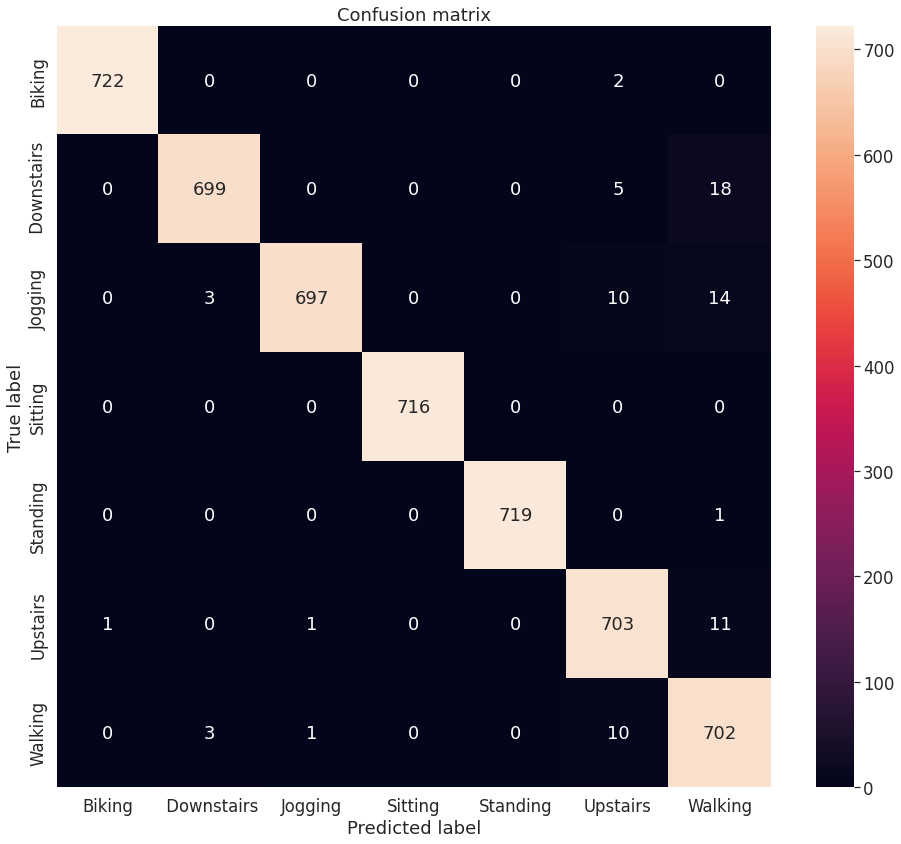

In [80]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

LABELS = ['Biking' ,' Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

## Exporting the model 

Finally we export the trained model in a format which easily can be used in our android application for on-device inference. The exported model will be named "frozen_HAR.pb" and be stored under models directory:

In [84]:
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

input_node_names= ["LSTM_1_input"]
output_node_name = "Dense_2/Softmax"
MODEL_NAME = "HAR"

tf.train.write_graph(K.get_session().graph_def, 'models', \
        MODEL_NAME + '_graph.pbtxt')
saver = tf.train.Saver()
saver.save(K.get_session(), 'models/' + MODEL_NAME + '.chkp')

'models/HAR.chkp'

In [85]:
# Reference: https://gist.github.com/JacHammer/b422d0e74400019817addf55cd72c6c3
def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + "/frozen_HAR.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return output_graph_def

freeze_graph("./models/", output_node_name)

INFO:tensorflow:Restoring parameters from ./models/HAR.chkp
110 ops in the final graph.


node {
  name: "LSTM_1_input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 100
        }
        dim {
          size: 12
        }
      }
    }
  }
}
node {
  name: "LSTM_1/lstm_cell_2/kernel"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 12
          }
          dim {
            size: 128
          }
        }
        tensor_content: "\355\240\027\275\350[\227\275\3633\020=\343\271\202=\r\334\242;\016\253!\276\301%?=V\322\325\275\312Y\037=\216iu=\023c\243=\310d\303\275\244\222\003\276\236\331\263=r\017o=R\3636<\001\250\361\275\024\241|\274\223\357?\275\334\374\252=2\022T\272>1R\276\227`\037=\252mO>r\267\251=\300\273\252\275\374\376u\271\200N>=\2329